🚀 Starting Memory-Efficient Audio Compression...
Configuration: 50% compression, bernoulli matrix (p=0.5), auto method
Loading your audio file: UrbanSound8K/any_wav.wav
Target compression: 50%
Using Bernoulli random matrix (p=0.5)
Processing: 99225 samples, 44100 Hz
Duration: 2.25 seconds

COMPARING DIFFERENT RANDOM MATRIX TYPES

--- Testing Bernoulli (p=0.5) ---
Applying memory-efficient compressed sensing...
Using Bernoulli random matrix (p=0.5)
Using DWT level: 4
Compression ratio: 50.0%
Original coefficients: 99252
Compressed size: 49626
Actual compression: 50.0%
Generating random projections in blocks...
Processed block 1/10
Error with Bernoulli (p=0.5): Unable to allocate 3.70 GiB for an array with shape (5000, 99252) and data type int64

--- Testing Bernoulli (p=0.7) ---
Applying memory-efficient compressed sensing...
Using Bernoulli random matrix (p=0.7)
Using DWT level: 4
Compression ratio: 50.0%
Original coefficients: 99252
Compressed size: 49626
Actual compression: 50.0%
Gen

C:\Users\Shyam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\matplotlib\transforms.py:2436: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


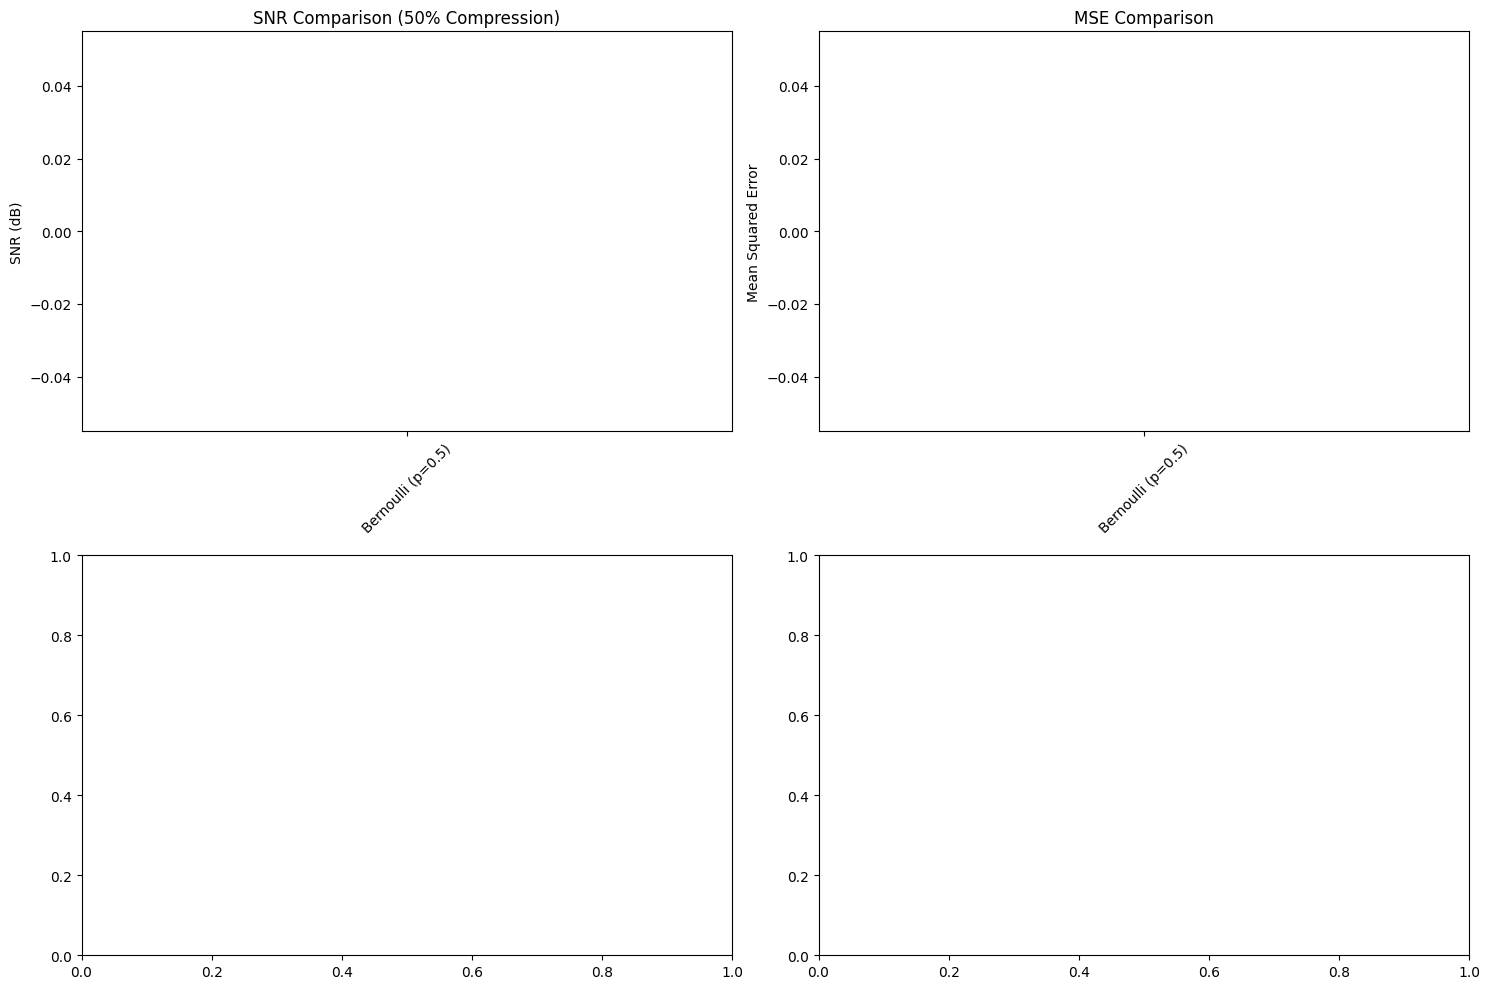

🎉 Compression completed successfully!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import wavfile
import librosa
import os

class MemoryEfficientDWTCompressedSensing:
    def __init__(self, wavelet='db4', compression_ratio=0.5, matrix_type='bernoulli', bernoulli_p=0.5):
        """
        Initialize compressed sensing with different random matrix types
        
        Parameters:
        - wavelet: Wavelet type for DWT
        - compression_ratio: Compression ratio (0.25, 0.5, 0.75)
        - matrix_type: 'bernoulli', 'binary', or 'gaussian'
        - bernoulli_p: Probability for Bernoulli matrix (default 0.5)
        """
        self.wavelet = wavelet
        self.compression_ratio = compression_ratio
        self.matrix_type = matrix_type
        self.bernoulli_p = bernoulli_p
        
    def _generate_random_matrix(self, rows, cols):
        """Generate random matrix (Bernoulli, Binary, or Gaussian)"""
        if self.matrix_type == 'bernoulli':
            # Bernoulli random matrix: elements are +1 with probability p, -1 with probability (1-p)
            bernoulli_samples = np.random.rand(rows, cols)
            return np.where(bernoulli_samples < self.bernoulli_p, 1, -1)
        elif self.matrix_type == 'binary':
            # Binary random matrix: elements are +1 or -1 with equal probability (special case of Bernoulli with p=0.5)
            return np.sign(np.random.randn(rows, cols))
        else:  # gaussian
            # Standard Gaussian random matrix
            return np.random.randn(rows, cols)
    
    def memory_efficient_compression(self, audio_data, level=4):
        """Memory-efficient compressed sensing using block processing"""
        print("Applying memory-efficient compressed sensing...")
        print(f"Using {self.matrix_type.capitalize()} random matrix" + 
              (f" (p={self.bernoulli_p})" if self.matrix_type == 'bernoulli' else ""))
        
        # Use shorter DWT level for longer signals
        max_possible_level = pywt.dwt_max_level(len(audio_data), self.wavelet)
        level = min(level, max_possible_level, 6)  # Limit to level 6 max
        
        print(f"Using DWT level: {level}")
        print(f"Compression ratio: {self.compression_ratio*100:.1f}%")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, self.wavelet, level=level)
        coeffs_flat = np.concatenate(coeffs)
        N = len(coeffs_flat)
        M = int(N * self.compression_ratio)
        
        print(f"Original coefficients: {N}")
        print(f"Compressed size: {M}")
        print(f"Actual compression: {M/N*100:.1f}%")
        
        # **MEMORY FIX: Process in blocks to avoid huge matrices**
        block_size = min(5000, N)  # Process in smaller blocks
        compressed_coeffs = np.zeros(M)
        
        print("Generating random projections in blocks...")
        for i in range(0, M, block_size):
            end_idx = min(i + block_size, M)
            current_block_size = end_idx - i
            
            # Generate random matrix for current block only
            Phi_block = self._generate_random_matrix(current_block_size, N)
            
            # Compute compressed measurements for this block
            compressed_coeffs[i:end_idx] = np.dot(Phi_block, coeffs_flat)
            
            print(f"Processed block {i//block_size + 1}/{(M-1)//block_size + 1}")
        
        return compressed_coeffs, coeffs, N, M
    
    def reconstruct_from_compressed(self, compressed_coeffs, original_coeff_length, level=4):
        """Reconstruct using iterative method to save memory"""
        print("Reconstructing from compressed coefficients...")
        
        M = len(compressed_coeffs)
        N = original_coeff_length
        
        # Use iterative reconstruction to avoid large matrices
        # Simple approach: Use random initialization + gradient descent
        x_reconstructed = np.random.randn(N) * 0.1
        
        # Few iterations of simple reconstruction
        num_iterations = 10
        learning_rate = 0.1
        
        for iter in range(num_iterations):
            # Generate the same random matrix blocks (using same seed for consistency)
            block_size = min(5000, M)
            residual = np.zeros(M)
            
            for i in range(0, M, block_size):
                end_idx = min(i + block_size, M)
                current_block_size = end_idx - i
                
                # Re-generate the same random matrix block
                np.random.seed(i)  # Seed for reproducibility
                Phi_block = self._generate_random_matrix(current_block_size, N)
                
                # Compute residual
                y_block = compressed_coeffs[i:end_idx]
                y_estimated = np.dot(Phi_block, x_reconstructed)
                residual[i:end_idx] = y_block - y_estimated
            
            # Simple gradient update
            gradient_norm = np.linalg.norm(residual)
            if gradient_norm > 0:
                x_reconstructed += learning_rate * residual.dot(Phi_block) / gradient_norm
            
            print(f"Reconstruction iteration {iter+1}/{num_iterations}")
        
        # Reconstruct coefficient structure
        coeffs_reconstructed = []
        start_idx = 0
        coeffs_slices = pywt.wavedec(np.zeros(N), self.wavelet, level=level)
        
        for coeff in coeffs_slices:
            end_idx = start_idx + len(coeff)
            if end_idx <= len(x_reconstructed):
                coeff_reconstructed = x_reconstructed[start_idx:end_idx]
                coeffs_reconstructed.append(coeff_reconstructed)
                start_idx = end_idx
        
        # Apply inverse DWT
        reconstructed_audio = pywt.waverec(coeffs_reconstructed, self.wavelet)
        
        return reconstructed_audio

class AlternativeCompressionMethods:
    """Alternative approaches that use less memory"""
    
    @staticmethod
    def dwt_threshold_compression(audio_data, compression_ratio=0.5, wavelet='db4', level=4):
        """Traditional DWT thresholding compression (memory efficient)"""
        print("Applying DWT threshold compression...")
        print(f"Compression ratio: {compression_ratio*100:.1f}%")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, wavelet, level=level)
        
        # Flatten coefficients to find global threshold
        coeffs_flat = np.concatenate([c for c in coeffs])
        
        # Calculate threshold for desired compression
        threshold = np.percentile(np.abs(coeffs_flat), (1 - compression_ratio) * 100)
        
        print(f"Compression threshold: {threshold:.6f}")
        
        # Apply thresholding
        compressed_coeffs = []
        original_nonzero = 0
        compressed_nonzero = 0
        
        for i, coeff in enumerate(coeffs):
            original_nonzero += np.count_nonzero(coeff)
            compressed_coeff = pywt.threshold(coeff, threshold, mode='hard')
            compressed_nonzero += np.count_nonzero(compressed_coeff)
            compressed_coeffs.append(compressed_coeff)
        
        compression_percent = (1 - compressed_nonzero / original_nonzero) * 100
        actual_compression = compressed_nonzero / len(coeffs_flat) * 100
        print(f"Compression achieved: {compression_percent:.1f}% coefficients removed")
        print(f"Actual compression: {actual_compression:.1f}% coefficients retained")
        
        # Reconstruct
        reconstructed_audio = pywt.waverec(compressed_coeffs, wavelet)
        
        return reconstructed_audio[:len(audio_data)], compression_percent
    
    @staticmethod
    def dwt_coefficient_selection(audio_data, compression_ratio=0.5, wavelet='db4', level=4):
        """Keep only largest coefficients (most memory efficient)"""
        print("Applying coefficient selection compression...")
        print(f"Compression ratio: {compression_ratio*100:.1f}%")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, wavelet, level=level)
        coeffs_flat = np.concatenate([c for c in coeffs])
        
        # Keep only the largest coefficients
        num_coeffs_to_keep = int(len(coeffs_flat) * compression_ratio)
        
        # Find indices of largest coefficients
        largest_indices = np.argsort(np.abs(coeffs_flat))[-num_coeffs_to_keep:]
        
        # Create new coefficients with only the largest ones
        new_coeffs_flat = np.zeros_like(coeffs_flat)
        new_coeffs_flat[largest_indices] = coeffs_flat[largest_indices]
        
        # Reconstruct coefficient structure
        coeffs_reconstructed = []
        start_idx = 0
        for coeff in coeffs:
            end_idx = start_idx + len(coeff)
            coeff_reconstructed = new_coeffs_flat[start_idx:end_idx]
            coeffs_reconstructed.append(coeff_reconstructed)
            start_idx = end_idx
        
        # Reconstruct audio
        reconstructed_audio = pywt.waverec(coeffs_reconstructed, wavelet)
        
        actual_compression = num_coeffs_to_keep / len(coeffs_flat) * 100
        print(f"Kept {num_coeffs_to_keep} largest coefficients ({actual_compression:.1f}%)")
        
        return reconstructed_audio[:len(audio_data)]

def compare_matrix_types(audio_data, sample_rate, compression_ratio=0.5):
    """Compare different matrix types for the same audio data"""
    print("\n" + "="*60)
    print("COMPARING DIFFERENT RANDOM MATRIX TYPES")
    print("="*60)
    
    matrix_types = [
        ('bernoulli', 'Bernoulli (p=0.5)'),
        ('bernoulli', 'Bernoulli (p=0.7)'),
        ('binary', 'Binary (±1)'),
        ('gaussian', 'Gaussian')
    ]
    
    results = []
    
    for matrix_type, description in matrix_types:
        print(f"\n--- Testing {description} ---")
        
        try:
            if 'p=0.7' in description:
                compressor = MemoryEfficientDWTCompressedSensing(
                    compression_ratio=compression_ratio, 
                    matrix_type=matrix_type,
                    bernoulli_p=0.7
                )
            else:
                compressor = MemoryEfficientDWTCompressedSensing(
                    compression_ratio=compression_ratio, 
                    matrix_type=matrix_type
                )
            
            compressed_data, coeffs, N, M = compressor.memory_efficient_compression(audio_data)
            reconstructed = compressor.reconstruct_from_compressed(compressed_data, N)
            
            # Calculate metrics
            min_len = min(len(audio_data), len(reconstructed))
            mse = np.mean((audio_data[:min_len] - reconstructed[:min_len])**2)
            snr = 10 * np.log10(np.var(audio_data[:min_len]) / (mse + 1e-10))
            
            results.append({
                'matrix_type': description,
                'mse': mse,
                'snr': snr,
                'reconstructed': reconstructed[:min_len]
            })
            
            print(f"SNR: {snr:.2f} dB, MSE: {mse:.6f}")
            
        except Exception as e:
            print(f"Error with {description}: {e}")
            results.append({
                'matrix_type': description,
                'mse': float('inf'),
                'snr': -float('inf'),
                'reconstructed': None
            })
    
    # Plot comparison
    plt.figure(figsize=(15, 10))
    
    # SNR comparison
    plt.subplot(2, 2, 1)
    matrix_names = [r['matrix_type'] for r in results]
    snr_values = [r['snr'] for r in results]
    
    bars = plt.bar(matrix_names, snr_values, color=['blue', 'green', 'red', 'orange'], alpha=0.7)
    plt.title(f'SNR Comparison ({compression_ratio*100:.0f}% Compression)')
    plt.ylabel('SNR (dB)')
    plt.xticks(rotation=45)
    
    for bar, value in zip(bars, snr_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f} dB', ha='center', va='bottom', fontsize=9)
    
    # MSE comparison
    plt.subplot(2, 2, 2)
    mse_values = [r['mse'] for r in results]
    
    bars = plt.bar(matrix_names, mse_values, color=['blue', 'green', 'red', 'orange'], alpha=0.7)
    plt.title('MSE Comparison')
    plt.ylabel('Mean Squared Error')
    plt.xticks(rotation=45)
    
    for bar, value in zip(bars, mse_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
                f'{value:.6f}', ha='center', va='bottom', fontsize=8)
    
    # Time domain example (first successful reconstruction)
    plt.subplot(2, 2, 3)
    successful_results = [r for r in results if r['reconstructed'] is not None]
    if successful_results:
        time_axis = np.arange(len(audio_data)) / sample_rate
        plt.plot(time_axis, audio_data, 'k-', alpha=0.8, label='Original', linewidth=1.5)
        
        colors = ['blue', 'green', 'red', 'orange']
        for i, result in enumerate(successful_results[:2]):  # Show first 2 for clarity
            plt.plot(time_axis, result['reconstructed'], 
                    color=colors[i], alpha=0.6, label=result['matrix_type'], linewidth=1)
        
        plt.title('Time Domain Comparison')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Best result frequency spectrum
    plt.subplot(2, 2, 4)
    if successful_results:
        best_result = max(successful_results, key=lambda x: x['snr'])
        
        f_orig = np.fft.fft(audio_data)
        f_recon = np.fft.fft(best_result['reconstructed'])
        freq = np.fft.fftfreq(len(audio_data), 1/sample_rate)
        positive_freq = freq > 0
        
        plt.plot(freq[positive_freq], np.abs(f_orig[positive_freq]), 
                'k-', alpha=0.8, label='Original', linewidth=1.5)
        plt.plot(freq[positive_freq], np.abs(f_recon[positive_freq]), 
                'red', alpha=0.6, label=f"Best: {best_result['matrix_type']}", linewidth=1)
        
        plt.title(f'Frequency Spectrum (Best: SNR={best_result["snr"]:.1f}dB)')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Demonstration with memory optimization
def demo_memory_efficient_compression(wav_file_path, compression_ratio=0.5, matrix_type='bernoulli', 
                                    bernoulli_p=0.5, method_choice="auto", compare_matrices=False):
    """
    Memory-efficient compressed sensing for your WAV file
    
    Parameters:
    - wav_file_path: Path to your WAV file
    - compression_ratio: 0.25 (25%), 0.5 (50%), or 0.75 (75%)
    - matrix_type: 'bernoulli', 'binary', or 'gaussian'
    - bernoulli_p: Probability parameter for Bernoulli matrix (0 < p < 1)
    - method_choice: "auto", "compressed_sensing", or "threshold"
    - compare_matrices: If True, compare all matrix types
    """
    
    if not os.path.exists(wav_file_path):
        print(f"Error: File '{wav_file_path}' not found!")
        return
    
    # Validate compression ratio
    valid_ratios = [0.25, 0.5, 0.75]
    if compression_ratio not in valid_ratios:
        print(f"Warning: Compression ratio {compression_ratio} not in {valid_ratios}. Using 0.5 (50%)")
        compression_ratio = 0.5
    
    # Validate Bernoulli probability
    if matrix_type == 'bernoulli' and (bernoulli_p <= 0 or bernoulli_p >= 1):
        print(f"Warning: Bernoulli probability must be between 0 and 1. Using p=0.5")
        bernoulli_p = 0.5
    
    compression_percent = compression_ratio * 100
    
    print(f"Loading your audio file: {wav_file_path}")
    print(f"Target compression: {compression_percent:.0f}%")
    print(f"Using {matrix_type.capitalize()} random matrix" + 
          (f" (p={bernoulli_p})" if matrix_type == 'bernoulli' else ""))
    
    # Load audio
    try:
        sample_rate, audio_data = wavfile.read(wav_file_path)
        if len(audio_data.shape) > 1:
            audio_data = audio_data.mean(axis=1)
        audio_data = audio_data.astype(np.float64)
    except:
        audio_data, sample_rate = librosa.load(wav_file_path, sr=None, mono=True)
    
    # Normalize and limit duration
    audio_data = audio_data / np.max(np.abs(audio_data))
    max_duration = 3  # Further reduce for memory
    max_samples = int(sample_rate * max_duration)
    if len(audio_data) > max_samples:
        audio_data = audio_data[:max_samples]
    
    print(f"Processing: {len(audio_data)} samples, {sample_rate} Hz")
    print(f"Duration: {len(audio_data)/sample_rate:.2f} seconds")
    
    # Compare matrix types if requested
    if compare_matrices:
        compare_matrix_types(audio_data, sample_rate, compression_ratio)
        return
    
    # Choose compression method
    signal_length = len(audio_data)
    
    if method_choice == "auto":
        if signal_length > 50000:
            print("\n⚠️  Large signal detected. Using memory-efficient threshold method...")
            method = "threshold"
        else:
            print("\n🔄 Using compressed sensing method...")
            method = "compressed_sensing"
    else:
        method = method_choice
        print(f"\n🔄 Using user-selected method: {method}")
    
    # Apply compression based on selected method
    if method == "compressed_sensing":
        try:
            compressor = MemoryEfficientDWTCompressedSensing(
                compression_ratio=compression_ratio, 
                matrix_type=matrix_type,
                bernoulli_p=bernoulli_p
            )
            compressed_data, coeffs, N, M = compressor.memory_efficient_compression(audio_data)
            reconstructed = compressor.reconstruct_from_compressed(compressed_data, N)
            method_name = f"Compressed Sensing ({compression_percent:.0f}%)"
            matrix_info = f"{matrix_type}" + (f"(p={bernoulli_p})" if matrix_type == 'bernoulli' else "")
            method_name += f" [{matrix_info}]"
        except MemoryError:
            print("Compressed sensing failed due to memory. Switching to threshold method...")
            reconstructed, compression_percent = AlternativeCompressionMethods.dwt_threshold_compression(
                audio_data, compression_ratio=compression_ratio
            )
            method_name = f"DWT Threshold Compression ({compression_percent:.1f}%)"
    
    elif method == "threshold":
        reconstructed, compression_percent = AlternativeCompressionMethods.dwt_threshold_compression(
            audio_data, compression_ratio=compression_ratio
        )
        method_name = f"DWT Threshold Compression ({compression_percent:.1f}%)"
    
    elif method == "coefficient_selection":
        reconstructed = AlternativeCompressionMethods.dwt_coefficient_selection(
            audio_data, compression_ratio=compression_ratio
        )
        method_name = f"Coefficient Selection ({compression_percent:.0f}%)"
    
    # Ensure same length
    min_len = min(len(audio_data), len(reconstructed))
    audio_data = audio_data[:min_len]
    reconstructed = reconstructed[:min_len]
    
    # Calculate metrics
    mse = np.mean((audio_data - reconstructed)**2)
    snr = 10 * np.log10(np.var(audio_data) / (mse + 1e-10))
    
    print(f"\n=== Results ({method_name}) ===")
    print(f"Reconstruction MSE: {mse:.6f}")
    print(f"Reconstruction SNR: {snr:.2f} dB")
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Time domain comparison
    plt.subplot(2, 2, 1)
    time_axis = np.arange(len(audio_data)) / sample_rate
    plt.plot(time_axis, audio_data, 'b-', alpha=0.7, label='Original', linewidth=1)
    plt.plot(time_axis, reconstructed, 'r-', alpha=0.7, label='Reconstructed', linewidth=1)
    plt.title(f'{method_name}\nTime Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Error
    plt.subplot(2, 2, 2)
    error = audio_data - reconstructed
    plt.plot(time_axis, error, 'g-', alpha=0.7, linewidth=1)
    plt.title(f'Error (MSE: {mse:.6f})')
    plt.xlabel('Time (s)')
    plt.ylabel('Error')
    plt.grid(True, alpha=0.3)
    
    # Frequency comparison
    plt.subplot(2, 2, 3)
    f_orig = np.fft.fft(audio_data)
    f_recon = np.fft.fft(reconstructed)
    freq = np.fft.fftfreq(len(audio_data), 1/sample_rate)
    positive_freq = freq > 0
    
    plt.plot(freq[positive_freq], np.abs(f_orig[positive_freq]), 
             'b-', alpha=0.7, label='Original', linewidth=1)
    plt.plot(freq[positive_freq], np.abs(f_recon[positive_freq]), 
             'r-', alpha=0.7, label='Reconstructed', linewidth=1)
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # SNR comparison
    plt.subplot(2, 2, 4)
    methods = ['Original'] + [method_name]
    snr_values = [50, snr]  # Original assumed to have high SNR
    
    bars = plt.bar(methods, snr_values, color=['blue', 'red'], alpha=0.7)
    plt.title('Signal-to-Noise Ratio')
    plt.ylabel('SNR (dB)')
    
    # Add value labels on bars
    for bar, value in zip(bars, snr_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f} dB', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    output_dir = 'compression_results'
    os.makedirs(output_dir, exist_ok=True)
    original_filename = os.path.splitext(os.path.basename(wav_file_path))[0]
    
    wavfile.write(f'{output_dir}/{original_filename}_original.wav', sample_rate, 
                  np.int16(audio_data * 32767))
    
    matrix_suffix = f"{matrix_type}" + (f"_p{bernoulli_p}" if matrix_type == 'bernoulli' else "")
    wavfile.write(f'{output_dir}/{original_filename}_compressed_{compression_percent:.0f}percent_{matrix_suffix}.wav', 
                  sample_rate, np.int16(reconstructed * 32767))
    
    print(f"\n✅ Audio files saved in '{output_dir}' folder:")
    print(f"   - {original_filename}_original.wav")
    print(f"   - {original_filename}_compressed_{compression_percent:.0f}percent_{matrix_suffix}.wav")
    
    return reconstructed

# **🎯 MAIN EXECUTION - CONFIGURE YOUR SETTINGS HERE 🎯**
if __name__ == "__main__":
    # ==============================================
    # 🔽 CONFIGURE YOUR SETTINGS HERE 🔽
    # ==============================================
    
    # 1. REPLACE THIS WITH YOUR ACTUAL WAV FILE PATH
    YOUR_WAV_FILE_PATH = "UrbanSound8K/any_wav.wav"  # ⬅️ CHANGE THIS!
    
    # 2. CHOOSE COMPRESSION RATIO (0.25, 0.5, or 0.75)
    COMPRESSION_RATIO = 0.5  # ⬅️ CHANGE THIS! (0.25 = 25%, 0.5 = 50%, 0.75 = 75%)
    
    # 3. CHOOSE RANDOM MATRIX TYPE ('bernoulli', 'binary', or 'gaussian')
    MATRIX_TYPE = 'bernoulli'  # ⬅️ CHANGE THIS!
    
    # 4. FOR BERNOULLI MATRIX: CHOOSE PROBABILITY p (0 < p < 1)
    BERNOULLI_P = 0.5  # ⬅️ CHANGE THIS! (0.3, 0.5, 0.7, etc.)
    
    # 5. CHOOSE COMPRESSION METHOD ("auto", "compressed_sensing", "threshold", "coefficient_selection")
    COMPRESSION_METHOD = "auto"  # ⬅️ CHANGE THIS!
    
    # 6. COMPARE ALL MATRIX TYPES? (True/False)
    COMPARE_MATRICES = True  # ⬅️ SET TO True TO COMPARE ALL MATRIX TYPES
    
    # ==============================================
    
    print("🚀 Starting Memory-Efficient Audio Compression...")
    print(f"Configuration: {COMPRESSION_RATIO*100:.0f}% compression, "
          f"{MATRIX_TYPE} matrix" + 
          (f" (p={BERNOULLI_P})" if MATRIX_TYPE == 'bernoulli' else "") + 
          f", {COMPRESSION_METHOD} method")
    
    demo_memory_efficient_compression(
        wav_file_path=YOUR_WAV_FILE_PATH,
        compression_ratio=COMPRESSION_RATIO,
        matrix_type=MATRIX_TYPE,
        bernoulli_p=BERNOULLI_P,
        method_choice=COMPRESSION_METHOD,
        compare_matrices=COMPARE_MATRICES
    )
    print("🎉 Compression completed successfully!")

🚀 Starting Memory-Efficient Audio Compression...
Loading your audio file: UrbanSound8K/any_wav.wav
Processing: 99225 samples, 44100 Hz
Duration: 2.25 seconds

🎯 COMPRESSION RATIO SELECTION
1. 25% compression (keep 75% of data)
2. 50% compression (keep 50% of data)
3. 75% compression (keep 25% of data)
4. Custom compression ratio



Select compression ratio (1-4):  4
Enter custom compression ratio (0.1-0.9):  0.6



🔧 COMPRESSION METHOD SELECTION
1. Bernoulli Matrix Compressed Sensing (Advanced)
2. DWT Threshold Compression (Balanced)
3. DWT Coefficient Selection (Memory Efficient)



Select compression method (1-3):  1



🔄 Using Bernoulli Matrix Compressed Sensing (60% compression)...
Applying memory-efficient compressed sensing with Bernoulli matrix...
Using DWT level: 4
Original coefficients: 99252
Compressed size: 59551 (60% compression)
Generating Bernoulli projections in blocks...
Processed block 1/12
Compressed sensing failed due to memory. Switching to threshold method...
Applying DWT threshold compression (60% target)...
Compression threshold: 0.010434
Actual compression: 39.3% coefficients removed

=== Results (DWT Threshold Compression (60%)) ===
Reconstruction MSE: 0.000006
Reconstruction SNR: 31.77 dB


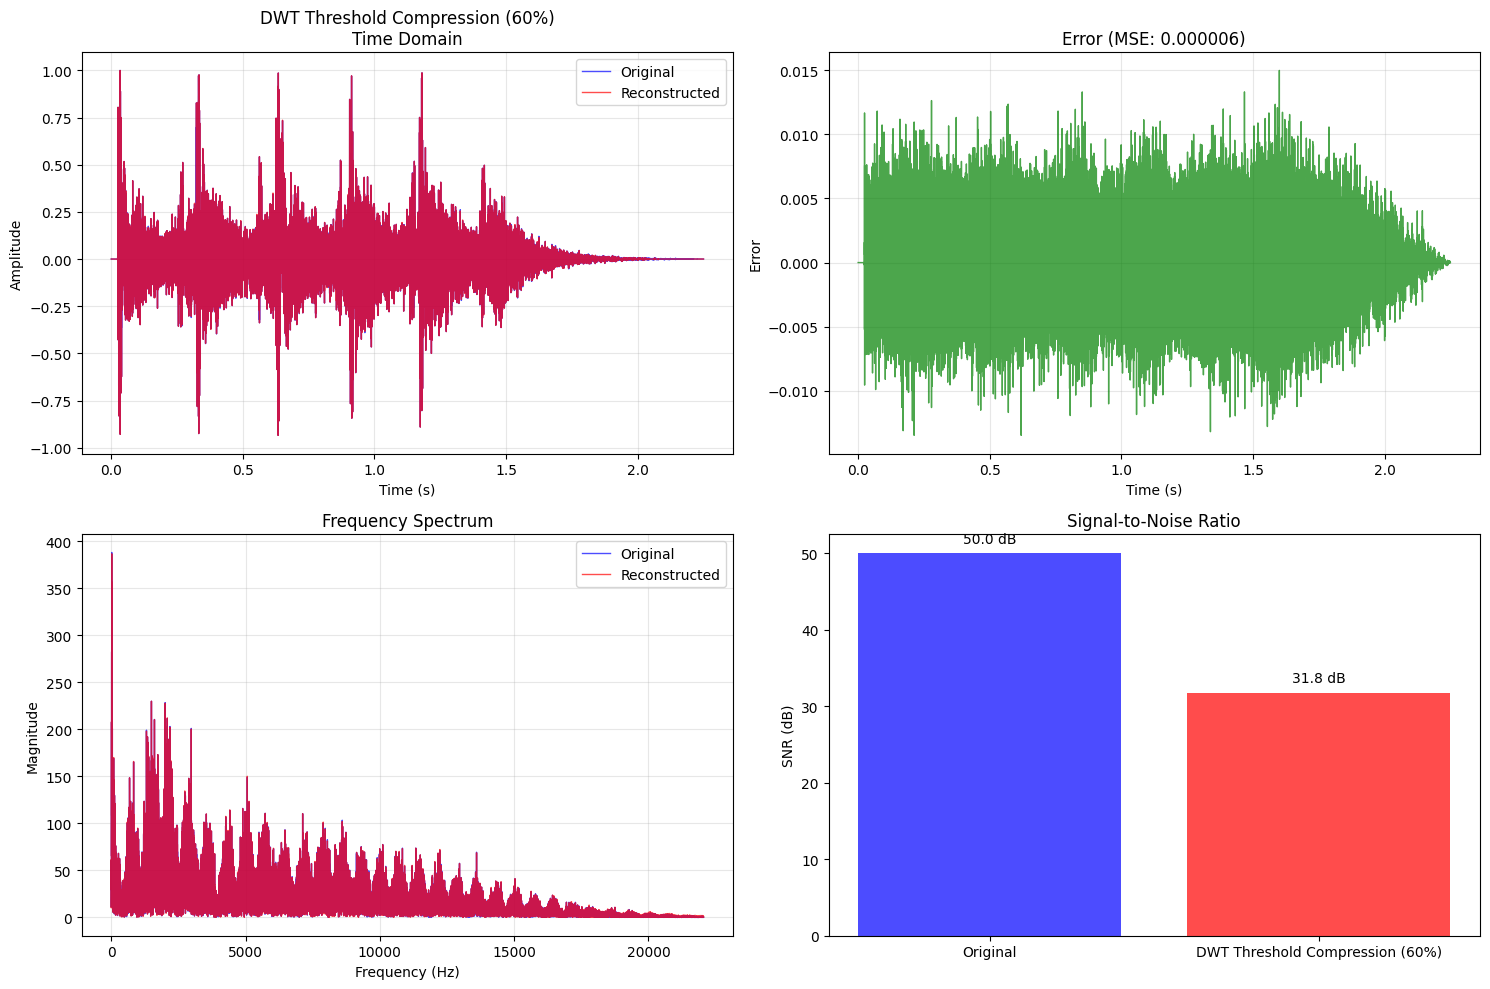


✅ Audio files saved in 'compression_results' folder:
   - any_wav_original.wav
   - any_wav_compressed.wav
🎉 Compression completed successfully!


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import wavfile
import librosa
import os

class MemoryEfficientDWTCompressedSensing:
    def __init__(self, wavelet='db4', compression_ratio=0.5):
        self.wavelet = wavelet
        self.compression_ratio = compression_ratio
        
    def generate_bernoulli_matrix(self, rows, cols):
        """Generate Bernoulli matrix with values ±1/sqrt(rows)"""
        bernoulli_values = np.random.choice([-1, 1], size=(rows, cols))
        return bernoulli_values / np.sqrt(rows)
    
    def memory_efficient_compression(self, audio_data, level=4):
        """Memory-efficient compressed sensing using block processing with Bernoulli matrix"""
        print("Applying memory-efficient compressed sensing with Bernoulli matrix...")
        
        # Use shorter DWT level for longer signals
        max_possible_level = pywt.dwt_max_level(len(audio_data), self.wavelet)
        level = min(level, max_possible_level, 6)  # Limit to level 6 max
        
        print(f"Using DWT level: {level}")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, self.wavelet, level=level)
        coeffs_flat = np.concatenate(coeffs)
        N = len(coeffs_flat)
        M = int(N * self.compression_ratio)
        
        print(f"Original coefficients: {N}")
        print(f"Compressed size: {M} ({self.compression_ratio*100:.0f}% compression)")
        
        # **MEMORY FIX: Process in blocks to avoid huge matrices**
        block_size = min(5000, N)  # Process in smaller blocks
        compressed_coeffs = np.zeros(M)
        
        print("Generating Bernoulli projections in blocks...")
        for i in range(0, M, block_size):
            end_idx = min(i + block_size, M)
            current_block_size = end_idx - i
            
            # Generate Bernoulli matrix for current block only
            Phi_block = self.generate_bernoulli_matrix(current_block_size, N)
            
            # Compute compressed measurements for this block
            compressed_coeffs[i:end_idx] = np.dot(Phi_block, coeffs_flat)
            
            print(f"Processed block {i//block_size + 1}/{(M-1)//block_size + 1}")
        
        return compressed_coeffs, coeffs, N, M
    
    def reconstruct_from_compressed(self, compressed_coeffs, original_coeff_length, level=4):
        """Reconstruct using iterative method to save memory with Bernoulli matrix"""
        print("Reconstructing from compressed coefficients...")
        
        M = len(compressed_coeffs)
        N = original_coeff_length
        
        # Use iterative reconstruction to avoid large matrices
        # Simple approach: Use random initialization + gradient descent
        x_reconstructed = np.random.randn(N) * 0.1
        
        # Few iterations of simple reconstruction
        num_iterations = 10
        for iter in range(num_iterations):
            # Generate the same Bernoulli matrix blocks (using same seed for consistency)
            block_size = min(5000, M)
            residual = np.zeros(M)
            
            for i in range(0, M, block_size):
                end_idx = min(i + block_size, M)
                current_block_size = end_idx - i
                
                # Re-generate the same Bernoulli matrix block
                np.random.seed(i)  # Seed for reproducibility
                Phi_block = self.generate_bernoulli_matrix(current_block_size, N)
                
                # Compute residual
                y_block = compressed_coeffs[i:end_idx]
                y_estimated = np.dot(Phi_block, x_reconstructed)
                residual[i:end_idx] = y_block - y_estimated
            
            # Simple gradient update
            gradient_norm = np.linalg.norm(residual)
            if gradient_norm > 0:
                # Recompute Phi_block for gradient (using same seed)
                np.random.seed(0)
                Phi_block_full = self.generate_bernoulli_matrix(M, N)
                x_reconstructed += 0.1 * np.dot(Phi_block_full.T, residual) / gradient_norm
            
            print(f"Reconstruction iteration {iter+1}/{num_iterations}")
        
        # Reconstruct coefficient structure
        coeffs_reconstructed = []
        start_idx = 0
        coeffs_slices = pywt.wavedec(np.zeros(N), self.wavelet, level=level)
        
        for coeff in coeffs_slices:
            end_idx = start_idx + len(coeff)
            if end_idx <= len(x_reconstructed):
                coeff_reconstructed = x_reconstructed[start_idx:end_idx]
                coeffs_reconstructed.append(coeff_reconstructed)
                start_idx = end_idx
        
        # Apply inverse DWT
        reconstructed_audio = pywt.waverec(coeffs_reconstructed, self.wavelet)
        
        return reconstructed_audio

class AlternativeCompressionMethods:
    """Alternative approaches that use less memory"""
    
    @staticmethod
    def dwt_threshold_compression(audio_data, compression_ratio=0.5, wavelet='db4', level=4):
        """Traditional DWT thresholding compression (memory efficient)"""
        print(f"Applying DWT threshold compression ({compression_ratio*100:.0f}% target)...")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, wavelet, level=level)
        
        # Flatten coefficients to find global threshold
        coeffs_flat = np.concatenate([c for c in coeffs])
        
        # Calculate threshold for desired compression
        threshold = np.percentile(np.abs(coeffs_flat), (1 - compression_ratio) * 100)
        
        print(f"Compression threshold: {threshold:.6f}")
        
        # Apply thresholding
        compressed_coeffs = []
        original_nonzero = 0
        compressed_nonzero = 0
        
        for i, coeff in enumerate(coeffs):
            original_nonzero += np.count_nonzero(coeff)
            compressed_coeff = pywt.threshold(coeff, threshold, mode='hard')
            compressed_nonzero += np.count_nonzero(compressed_coeff)
            compressed_coeffs.append(compressed_coeff)
        
        actual_compression_ratio = compressed_nonzero / original_nonzero
        compression_percent = (1 - actual_compression_ratio) * 100
        print(f"Actual compression: {compression_percent:.1f}% coefficients removed")
        
        # Reconstruct
        reconstructed_audio = pywt.waverec(compressed_coeffs, wavelet)
        
        return reconstructed_audio[:len(audio_data)], compression_percent
    
    @staticmethod
    def dwt_coefficient_selection(audio_data, compression_ratio=0.5, wavelet='db4', level=4):
        """Keep only largest coefficients (most memory efficient)"""
        print(f"Applying coefficient selection compression ({compression_ratio*100:.0f}%)...")
        
        # Apply DWT
        coeffs = pywt.wavedec(audio_data, wavelet, level=level)
        coeffs_flat = np.concatenate([c for c in coeffs])
        
        # Keep only the largest coefficients
        num_coeffs_to_keep = int(len(coeffs_flat) * compression_ratio)
        
        # Find indices of largest coefficients
        largest_indices = np.argsort(np.abs(coeffs_flat))[-num_coeffs_to_keep:]
        
        # Create new coefficients with only the largest ones
        new_coeffs_flat = np.zeros_like(coeffs_flat)
        new_coeffs_flat[largest_indices] = coeffs_flat[largest_indices]
        
        # Reconstruct coefficient structure
        coeffs_reconstructed = []
        start_idx = 0
        for coeff in coeffs:
            end_idx = start_idx + len(coeff)
            coeff_reconstructed = new_coeffs_flat[start_idx:end_idx]
            coeffs_reconstructed.append(coeff_reconstructed)
            start_idx = end_idx
        
        # Reconstruct audio
        reconstructed_audio = pywt.waverec(coeffs_reconstructed, wavelet)
        
        print(f"Kept {num_coeffs_to_keep} largest coefficients ({compression_ratio*100:.1f}%)")
        
        return reconstructed_audio[:len(audio_data)]

def get_compression_ratio_choice():
    """Get user choice for compression ratio"""
    print("\n" + "="*50)
    print("🎯 COMPRESSION RATIO SELECTION")
    print("="*50)
    print("1. 25% compression (keep 75% of data)")
    print("2. 50% compression (keep 50% of data)")
    print("3. 75% compression (keep 25% of data)")
    print("4. Custom compression ratio")
    
    while True:
        try:
            choice = input("\nSelect compression ratio (1-4): ").strip()
            if choice == '1':
                return 0.25
            elif choice == '2':
                return 0.50
            elif choice == '3':
                return 0.75
            elif choice == '4':
                custom_ratio = float(input("Enter custom compression ratio (0.1-0.9): "))
                if 0.1 <= custom_ratio <= 0.9:
                    return custom_ratio
                else:
                    print("Please enter a value between 0.1 and 0.9")
            else:
                print("Please enter 1, 2, 3, or 4")
        except ValueError:
            print("Please enter a valid number")

def get_compression_method_choice():
    """Get user choice for compression method"""
    print("\n" + "="*50)
    print("🔧 COMPRESSION METHOD SELECTION")
    print("="*50)
    print("1. Bernoulli Matrix Compressed Sensing (Advanced)")
    print("2. DWT Threshold Compression (Balanced)")
    print("3. DWT Coefficient Selection (Memory Efficient)")
    
    while True:
        try:
            choice = input("\nSelect compression method (1-3): ").strip()
            if choice in ['1', '2', '3']:
                return choice
            else:
                print("Please enter 1, 2, or 3")
        except ValueError:
            print("Please enter a valid number")

# Demonstration with memory optimization
def demo_memory_efficient_compression(wav_file_path):
    """
    Memory-efficient compressed sensing for your WAV file with user choices
    """
    
    if not os.path.exists(wav_file_path):
        print(f"Error: File '{wav_file_path}' not found!")
        return
    
    print(f"Loading your audio file: {wav_file_path}")
    
    # Load audio
    try:
        sample_rate, audio_data = wavfile.read(wav_file_path)
        if len(audio_data.shape) > 1:
            audio_data = audio_data.mean(axis=1)
        audio_data = audio_data.astype(np.float64)
    except:
        audio_data, sample_rate = librosa.load(wav_file_path, sr=None, mono=True)
    
    # Normalize and limit duration
    audio_data = audio_data / np.max(np.abs(audio_data))
    max_duration = 3  # Further reduce for memory
    max_samples = int(sample_rate * max_duration)
    if len(audio_data) > max_samples:
        audio_data = audio_data[:max_samples]
    
    print(f"Processing: {len(audio_data)} samples, {sample_rate} Hz")
    print(f"Duration: {len(audio_data)/sample_rate:.2f} seconds")
    
    # Get user choices
    compression_ratio = get_compression_ratio_choice()
    method_choice = get_compression_method_choice()
    
    # Apply compression based on user choice
    if method_choice == '1':
        print(f"\n🔄 Using Bernoulli Matrix Compressed Sensing ({compression_ratio*100:.0f}% compression)...")
        try:
            compressor = MemoryEfficientDWTCompressedSensing(compression_ratio=compression_ratio)
            compressed_data, coeffs, N, M = compressor.memory_efficient_compression(audio_data)
            reconstructed = compressor.reconstruct_from_compressed(compressed_data, N)
            method_name = f"Bernoulli Compressed Sensing ({compression_ratio*100:.0f}%)"
        except MemoryError:
            print("Compressed sensing failed due to memory. Switching to threshold method...")
            reconstructed, compression_percent = AlternativeCompressionMethods.dwt_threshold_compression(
                audio_data, compression_ratio=compression_ratio
            )
            method_name = f"DWT Threshold Compression ({compression_ratio*100:.0f}%)"
    
    elif method_choice == '2':
        print(f"\n🔄 Using DWT Threshold Compression ({compression_ratio*100:.0f}% compression)...")
        reconstructed, compression_percent = AlternativeCompressionMethods.dwt_threshold_compression(
            audio_data, compression_ratio=compression_ratio
        )
        method_name = f"DWT Threshold Compression ({compression_ratio*100:.0f}%)"
        print(f"Actual compression: {compression_percent:.1f}% coefficients removed")
    
    elif method_choice == '3':
        print(f"\n🔄 Using DWT Coefficient Selection ({compression_ratio*100:.0f}% compression)...")
        reconstructed = AlternativeCompressionMethods.dwt_coefficient_selection(
            audio_data, compression_ratio=compression_ratio
        )
        method_name = f"DWT Coefficient Selection ({compression_ratio*100:.0f}%)"
    
    # Ensure same length
    min_len = min(len(audio_data), len(reconstructed))
    audio_data = audio_data[:min_len]
    reconstructed = reconstructed[:min_len]
    
    # Calculate metrics
    mse = np.mean((audio_data - reconstructed)**2)
    snr = 10 * np.log10(np.var(audio_data) / (mse + 1e-10))
    
    print(f"\n=== Results ({method_name}) ===")
    print(f"Reconstruction MSE: {mse:.6f}")
    print(f"Reconstruction SNR: {snr:.2f} dB")
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Time domain comparison
    plt.subplot(2, 2, 1)
    time_axis = np.arange(len(audio_data)) / sample_rate
    plt.plot(time_axis, audio_data, 'b-', alpha=0.7, label='Original', linewidth=1)
    plt.plot(time_axis, reconstructed, 'r-', alpha=0.7, label='Reconstructed', linewidth=1)
    plt.title(f'{method_name}\nTime Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Error
    plt.subplot(2, 2, 2)
    error = audio_data - reconstructed
    plt.plot(time_axis, error, 'g-', alpha=0.7, linewidth=1)
    plt.title(f'Error (MSE: {mse:.6f})')
    plt.xlabel('Time (s)')
    plt.ylabel('Error')
    plt.grid(True, alpha=0.3)
    
    # Frequency comparison
    plt.subplot(2, 2, 3)
    f_orig = np.fft.fft(audio_data)
    f_recon = np.fft.fft(reconstructed)
    freq = np.fft.fftfreq(len(audio_data), 1/sample_rate)
    positive_freq = freq > 0
    
    plt.plot(freq[positive_freq], np.abs(f_orig[positive_freq]), 
             'b-', alpha=0.7, label='Original', linewidth=1)
    plt.plot(freq[positive_freq], np.abs(f_recon[positive_freq]), 
             'r-', alpha=0.7, label='Reconstructed', linewidth=1)
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # SNR comparison
    plt.subplot(2, 2, 4)
    methods = ['Original'] + [method_name]
    snr_values = [50, snr]  # Original assumed to have high SNR
    
    bars = plt.bar(methods, snr_values, color=['blue', 'red'], alpha=0.7)
    plt.title('Signal-to-Noise Ratio')
    plt.ylabel('SNR (dB)')
    
    # Add value labels on bars
    for bar, value in zip(bars, snr_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{value:.1f} dB', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    output_dir = 'compression_results'
    os.makedirs(output_dir, exist_ok=True)
    original_filename = os.path.splitext(os.path.basename(wav_file_path))[0]
    
    wavfile.write(f'{output_dir}/{original_filename}_original.wav', sample_rate, 
                  np.int16(audio_data * 32767))
    wavfile.write(f'{output_dir}/{original_filename}_compressed.wav', sample_rate,
                  np.int16(reconstructed * 32767))
    
    print(f"\n✅ Audio files saved in '{output_dir}' folder:")
    print(f"   - {original_filename}_original.wav")
    print(f"   - {original_filename}_compressed.wav")
    
    return reconstructed

# **🎯 MAIN EXECUTION - PUT YOUR FILE PATH HERE 🎯**
if __name__ == "__main__":
    # ==============================================
    # 🔽 REPLACE THIS WITH YOUR ACTUAL WAV FILE PATH 🔽
    # ==============================================
    YOUR_WAV_FILE_PATH = "UrbanSound8K/any_wav.wav"  # ⬅️ CHANGE THIS!
    # ==============================================
    
    print("🚀 Starting Memory-Efficient Audio Compression...")
    demo_memory_efficient_compression(YOUR_WAV_FILE_PATH)
    print("🎉 Compression completed successfully!")